In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val
from src.homps import homps
from src.hops import hops

In [3]:
# parameters for the bath correlation functions
g = np.array([2])
w = np.array([0.5+2j])
# time
duration = 50
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
h = operators.generate_spin_boson_hamiltonian()
L = sigma_z

Without noise:


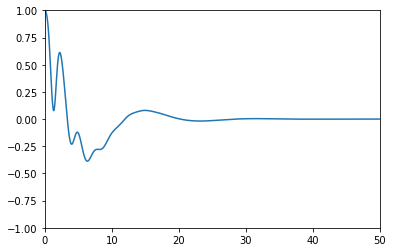

With noise:


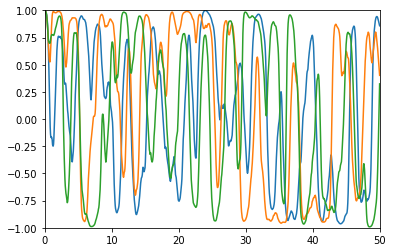

In [4]:
N_steps = 1000
N_trunc = 8
options = {
    'linear' : True,
    'use_noise' : False,
    'method' : 'RK4',
    'chi_max' : 10,
    'eps' : 1.e-15
}

print("Without noise:")
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis = my_homps.compute_realizations(1)
sigma_zs = compute_exp_val(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

print("With noise:")
options['use_noise'] = True
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
for i in range(3):
    psis = my_homps.compute_realizations(1)
    sigma_zs = compute_exp_val(psis, sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

In [5]:
N_steps = 1000
N_trunc = 16
options = {
    'linear' : True,
    'use_noise' : True,
    'method' : 'RK4',
    'chi_max' : 10,
    'eps' : 1.e-15
}

In [6]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)

In [7]:
psis_100 = my_homps.compute_realizations(N_samples=100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
psis_1000 = my_homps.compute_realizations(N_samples=1000, progressBar=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
sigma_zs_100 = compute_exp_val(psis_100, sigma_z)

In [11]:
sigma_zs_1000 = compute_exp_val(psis_1000, sigma_z)

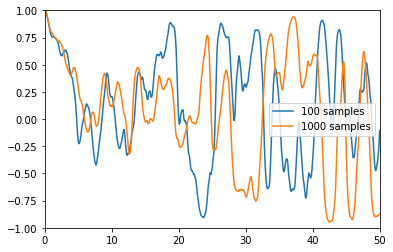

In [12]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
plt.legend(loc="right")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()